<a href="https://colab.research.google.com/github/aloha4you/roads/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22train_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import re

def load_image(infilename):
    """ Load an image from disk. """
    return mpimg.imread(infilename)

def pad_image(data, padding):
    """
    Extend the canvas of an image. Mirror boundary conditions are applied.
    """
    if len(data.shape) < 3:
        # Greyscale image (ground truth)
        data = np.lib.pad(data, ((padding, padding), (padding, padding)), 'reflect')
    else:
        # RGB image
        data = np.lib.pad(data, ((padding, padding), (padding, padding), (0,0)), 'reflect')
    return data
    
def img_crop_gt(im, w, h, stride):
    """ Crop an image into patches (this method is intended for ground truth images). """
    assert len(im.shape) == 2, 'Expected greyscale image.'
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    for i in range(0,imgheight,stride):
        for j in range(0,imgwidth,stride):
            im_patch = im[j:j+w, i:i+h]
            list_patches.append(im_patch)
    return list_patches
    
def img_crop(im, w, h, stride, padding):
    """ Crop an image into patches, taking into account mirror boundary conditions. """
    assert len(im.shape) == 3, 'Expected RGB image.'
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    im = np.lib.pad(im, ((padding, padding), (padding, padding), (0,0)), 'reflect')
    for i in range(padding,imgheight+padding,stride):
        for j in range(padding,imgwidth+padding,stride):
            im_patch = im[j-padding:j+w+padding, i-padding:i+h+padding, :]
            list_patches.append(im_patch)
    return list_patches
    
def create_patches(X, patch_size, stride, padding):
    img_patches = np.asarray([img_crop(X[i], patch_size, patch_size, stride, padding) for i in range(X.shape[0])])
    # Linearize list
    img_patches = img_patches.reshape(-1, img_patches.shape[2], img_patches.shape[3], img_patches.shape[4])
    return img_patches
    
def create_patches_gt(X, patch_size, stride):
    img_patches = np.asarray([img_crop_gt(X[i], patch_size, patch_size, stride) for i in range(X.shape[0])])
    # Linearize list
    img_patches = img_patches.reshape(-1, img_patches.shape[2], img_patches.shape[3])
    return img_patches
    
def group_patches(patches, num_images):
    return patches.reshape(num_images, -1)

def extract_img_features(filename, stride):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size, stride, padding)
    X = np.asarray([img_patches[i] for i in range(len(img_patches))])
    return X

def mask_to_submission_strings(model, image_filename):
    """ Reads a single image and outputs the strings that should go into the submission file. """
    img_number = int(re.search(r"\d+", image_filename).group(0))
    Xi = load_image(image_filename)
    Xi = Xi.reshape(1, Xi.shape[0], Xi.shape[1], Xi.shape[2])
    Zi = model.classify(Xi)
    Zi = Zi.reshape(-1)
    patch_size = 16
    nb = 0
    print("Processing " + image_filename)
    for j in range(0, Xi.shape[2], patch_size):
        for i in range(0, Xi.shape[1], patch_size):
            label = int(Zi[nb])
            nb += 1
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def generate_submission(model, submission_filename, *image_filenames):
    """ Generate a .csv containing the classification of the test set. """
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(model, fn))

# Load the training set
root_dir = "../training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)
print("Loading " + str(n) + " images")
imgs = np.asarray([load_image(image_dir + files[i]) for i in range(n)])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = np.asarray([load_image(gt_dir + files[i]) for i in range(n)])

Loading 100 images
Loading 100 images


In [7]:
#@title Текст заголовка по умолчанию
# -*- coding: utf-8 -*-

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import backend as K
from keras.regularizers import l2
from keras.layers import LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

class CnnModel:
    
    def __init__(self):
        """ Construct a CNN classifier. """
        
        self.patch_size = 16
        self.window_size = 72
        self.padding = (self.window_size - self.patch_size) // 2
        self.initialize()
        
    def initialize(self):
        """ Initialize or reset this model. """
        patch_size = self.patch_size
        window_size = self.window_size
        padding = self.padding
        nb_classes = 2
        
        # Size of pooling area for max pooling
        pool_size = (2, 2)

        # Compatibility with Theano and Tensorflow ordering
        if K.image_data_format() == 'th':
            input_shape = (3, window_size, window_size)
        else:
            input_shape = (window_size, window_size, 3)

        reg = 1e-6 # L2 regularization factor (used on weights, but not biases)

        self.model = Sequential()

        self.model.add(Convolution2D(64, 5, 5, # 64 5x5 filters
                                padding='same',
                                input_shape=input_shape
                               ))
        self.model.add(LeakyReLU(alpha=0.1))
        self.model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
        self.model.add(Dropout(0.25))

        self.model.add(Convolution2D(128, 3, 3, # 128 3x3 filters
                                padding='same'
                               ))
        self.model.add(LeakyReLU(alpha=0.1))
        self.model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
        self.model.add(Dropout(0.25))

        self.model.add(Convolution2D(256, 3, 3, # 256 3x3 filters
                                padding='same'
                               ))
        self.model.add(LeakyReLU(alpha=0.1))
        self.model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
        self.model.add(Dropout(0.25))

        self.model.add(Convolution2D(256, 3, 3, # 256 3x3 filters
                                padding='same'
                               ))
        self.model.add(LeakyReLU(alpha=0.1))
        self.model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
        self.model.add(Dropout(0.25))

        self.model.add(Flatten())
        self.model.add(Dense(128, kernel_regularizer=l2(reg)
                            )) # Fully connected layer (128 neurons)
        self.model.add(LeakyReLU(alpha=0.1))
        self.model.add(Dropout(0.5))

        self.model.add(Dense(nb_classes, kernel_regularizer=l2(reg)
                            ))
        
    
    def train(self, Y, X):
        """
        Train this model with the given dataset.
        """
        
        patch_size = self.patch_size
        window_size = self.window_size
        padding = self.padding
        
        print('Training set shape: ', X.shape)
        samples_per_epoch = X.shape[0]*X.shape[1]*X.shape[2]//256 # Arbitrary value
        
        # Pad training set images (by appling mirror boundary conditions)
        X_new = np.empty((X.shape[0],
                         X.shape[1] + 2*padding, X.shape[2] + 2*padding,
                         X.shape[3]))
        Y_new = np.empty((Y.shape[0],
                         Y.shape[1] + 2*padding, Y.shape[2] + 2*padding))
        for i in range(X.shape[0]):
            X_new[i] = pad_image(X[i], padding)
            Y_new[i] = pad_image(Y[i], padding)
        X = X_new
        Y = Y_new
            
        batch_size = 125
        nb_classes = 2
        nb_epoch = 1

        def softmax_categorical_crossentropy(y_true, y_pred):
            """
            Uses categorical cross-entropy from logits in order to improve numerical stability.
            This is especially useful for TensorFlow (less useful for Theano).
            """
            return K.categorical_crossentropy(y_pred, y_true, from_logits=True)

        opt = Adam(lr=0.001) # Adam optimizer with default initial learning rate
        self.model.compile(loss=softmax_categorical_crossentropy,
                      optimizer=opt,
                      metrics=['accuracy'])

        np.random.seed(3) # Ensure determinism
        
        def generate_minibatch():
            """
            Procedure for real-time minibatch creation and image augmentation.
            This runs in a parallel thread while the model is being trained.
            """
            while 1:
                # Generate one minibatch
                X_batch = np.empty((batch_size, window_size, window_size, 3))
                Y_batch = np.empty((batch_size, 2))
                for i in range(batch_size):
                    # Select a random image
                    idx = np.random.choice(X.shape[0])
                    shape = X[idx].shape
                    
                    # Sample a random window from the image
                    center = np.random.randint(window_size//2, shape[0] - window_size//2, 2)
                    sub_image = X[idx][center[0]-window_size//2:center[0]+window_size//2,
                                       center[1]-window_size//2:center[1]+window_size//2]
                    gt_sub_image = Y[idx][center[0]-patch_size//2:center[0]+patch_size//2,
                                          center[1]-patch_size//2:center[1]+patch_size//2]
                    
                    # The label does not depend on the image rotation/flip (provided that the rotation is in steps of 90°)
                    threshold = 0.25
                    label = (np.array([np.mean(gt_sub_image)]) > threshold) * 1
                    
                    # Image augmentation
                    # Random flip
                    if np.random.choice(2) == 0:
                        # Flip vertically
                        sub_image = np.flipud(sub_image)
                    if np.random.choice(2) == 0:
                        # Flip horizontally
                        sub_image = np.fliplr(sub_image)
                    
                    # Random rotation in steps of 90°
                    num_rot = np.random.choice(4)
                    sub_image = np.rot90(sub_image, num_rot)

                    label = np_utils.to_categorical(label, nb_classes)
                    X_batch[i] = sub_image
                    Y_batch[i] = label
                
                if K.image_data_format() == 'th':
                    X_batch = np.rollaxis(X_batch, 3, 1)
                    
                yield (X_batch, Y_batch)

        # This callback reduces the learning rate when the training accuracy does not improve any more
        lr_callback = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=5,
                                        verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
        
        # Stops the training process upon convergence
        stop_callback = EarlyStopping(monitor='acc', min_delta=0.0001, patience=11, verbose=1, mode='auto')
        
        try:
            self.model.fit_generator(generate_minibatch(),
                            steps_per_epoch=samples_per_epoch,
                            epochs=nb_epoch,
                            verbose=1,
                            callbacks=[lr_callback, stop_callback])
        except KeyboardInterrupt:
            # Do not throw away the model in case the user stops the training process
            pass

        print('Training completed')
        
    def save(self, filename):
        """ Save the weights of this model. """
        self.model.save_weights(filename)
        
    def load(self, filename):
        """ Load the weights for this model from a file. """
        self.model.load_weights(filename)
        
    def classify(self, X):
        """
        Classify an unseen set of samples.
        This method must be called after "train".
        Returns a list of predictions.
        """
        # Subdivide the images into blocks
        img_patches = create_patches(X, self.patch_size, 16, self.padding)
        
        #if K.image_dim_ordering() == 'th':
         #   img_patches = np.rollaxis(img_patches, 3, 1)
        
        # Run prediction
        Z = self.model.predict(img_patches)
        Z = (Z[:,0] < Z[:,1]) * 1
        
        # Regroup patches into images
        return group_patches(Z, X.shape[0])


# Load model from disk
model = CnnModel()

In [8]:
np.random.seed(1) # Ensure reproducibility

model.model.summary()
model.train(gt_imgs, imgs)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 15, 15, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 15, 15, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 3, 3, 128)         0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 128)        

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


62500/62500 [==============================] - 2141s 34ms/step - loss: nan - accuracy: 0.7421
Training completed


In [9]:
# Save weights to disk
model.save('../w.h5')

In [10]:
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

class LogisticModel:
    
    def __init__(self):
        """
        Construct a logistic regression classifier.
        """
        self.patch_size = 16

    def initialize(self):
        """ Initialize or reset this model. """
        self.logreg = linear_model.LogisticRegression(C=1e5)
    
    def extract_features(self, img):
        """
        Extract features from a patch:
        - Average color for each RGB channel
        - Standard deviation for each RGB channel
        """
        feat_m = np.mean(img, axis=(0,1))
        feat_v = np.std(img, axis=(0,1))
        feat = np.append(feat_m, feat_v)
        return feat
    
    def poly_fit(self, X):
        """
        Fit the dataset using a polynomial basis.
        """
        poly = PolynomialFeatures(4, interaction_only=False)
        return poly.fit_transform(X)
    
    # Extract features for a given image
    def extract_img_features(self, filename):
        img = load_image(filename)
        img_patches = img_crop(img, patch_size, patch_size)
        X = np.asarray([self.extract_features(img_patches[i]) for i in range(len(img_patches))])
        return X
    
    def train(self, Y, X):
        """
        Train this model.
        """
        
        foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

        def value_to_class(v):
            df = np.sum(v)
            if df > foreground_threshold:
                return 1
            else:
                return 0
        
        # Extract patches from input images
        patch_size = self.patch_size
        img_patches = [img_crop(X[i], patch_size, patch_size, patch_size, 0) for i in range(X.shape[0])]
        gt_patches = [img_crop_gt(Y[i], patch_size, patch_size, patch_size) for i in range(X.shape[0])]

        # Linearize list of patches
        img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
        gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
        
        X = np.asarray([self.extract_features(img_patches[i]) for i in range(len(img_patches))])
        Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
           
        X = self.poly_fit(X)
        self.logreg.fit(X, Y)
        
        print('Training completed')
        
    def save(self, filename):
        # Nothing to do
        return
        
    def load(self, filename):
        # Nothing to do
        return
        
    def classify(self, X):
        """
        Classify an unseen set of samples.
        This method must be called after "train".
        Returns a list of predictions.
        """
        patch_size = self.patch_size
        img_patches = [img_crop(X[i], patch_size, patch_size, patch_size, 0) for i in range(X.shape[0])]
        img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
        X = np.asarray([self.extract_features(img_patches[i]) for i in range(len(img_patches))])
        X = self.poly_fit(X)
        Z = self.logreg.predict(X)
        # Regroup patches into images
        return group_patches(Z, X.shape[0])

#model = NaiveModel()
#model = CnnModel()
model2 = LogisticModel()

In [ ]:
def build_k_indices(y, k_fold, seed):
    """
    Build k indices for k-fold cross-validation.
    """
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def get_classification_results(y, y_test):
    """
    Get the ratio of correct answers.
    """
    y = y.reshape(-1) # Linearize
    y_test = y_test.reshape(-1) # Linearize
    diff = y - y_test
    correct = np.sum(diff == 0)
    return correct / y_test.size

def cross_validation_iteration(model, Y, X, k_indices, k):
    """
    Execute a single run of cross-validation.
    Returns the ratio of correct answers on the validation set.
    """
    non_k_indices = k_indices[np.arange(k_indices.shape[0]) != k].ravel()
    tx_tr = X[non_k_indices]
    y_tr = Y[non_k_indices]
    tx_te = X[k_indices[k]]
    y_te = Y[k_indices[k]]
    
    model.initialize() # Reset model
    model.train(y_tr, tx_tr)
    #model.save('cv_' + str(k)) # For debug purposes
    
    # Run classification
    Z = model.classify(tx_te)
    
    # Calculate ground-truth labels
    img_patches_gt = create_patches_gt(y_te, 16, 16)
    y_real = np.mean(img_patches_gt, axis=(1, 2)) > 0.25
    
    return get_classification_results(y_real, Z)    
    
def k_fold_cross_validation(model, Y, X, k_fold, seed):
    """
    Run a full k-fold cross-validation and print mean accuracy and standard deviation.
    """
    np.random.seed(seed)
    k_indices = build_k_indices(Y, k_fold, seed)
    results = np.zeros(k_fold)
    for k in range(k_fold):
        results[k] = cross_validation_iteration(model, Y, X, k_indices, k)
        print('Accuracy: ' + str(results[k]))
    print(results)
    print('Cross validation accuracy: ' + str(np.mean(results)) + ', std=' + str(np.std(results)))
    
def fast_cross_validation(model, Y, X, k_fold, seed):
    """
    Execute cross-validation with a static validation set,
    i.e. a single run of k-fold cross-validation.
    """
    np.random.seed(seed)
    k_indices = build_k_indices(Y, k_fold, seed)
    result = cross_validation_iteration(model, Y, X, k_indices, 0)
    print('Cross validation accuracy: ' + str(result))

np.random.seed(1) # Ensure reproducibility
# Fast (partial) cross validation
k_fold_cross_validation(model2, gt_imgs, imgs, 5, 2)

In [12]:
model2.save('../m2aaaaa.h5')

In [18]:
patch_size = 16
padding = 54
stride = 16
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels, stride):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,stride):
        for j in range(0,imgwidth,stride):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def pad_image(data, padding):
    if len(data.shape) < 3:
        data = np.lib.pad(data, ((padding, padding), (padding, padding)), 'reflect')
    else:
        data = np.lib.pad(data, ((padding, padding), (padding, padding), (0,0)), 'reflect')
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h, stride, ext):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    if not is_2d:
        im = np.lib.pad(im, ((ext, ext), (ext, ext), (0,0)), 'reflect')
    for i in range(ext,imgheight+ext,stride):
        for j in range(ext,imgwidth+ext,stride):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                #im_patch = im[j:j+w, i:i+h, :]
                im_patch = im[j-ext:j+w+ext, i-ext:i+h+ext, :]
            list_patches.append(im_patch)
    return list_patches

# Extract features for a given image
def extract_img_features(filename, stride):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size, stride, padding)
    X = np.asarray([img_patches[i] for i in range(len(img_patches))])
    return X

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


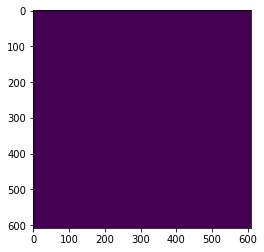

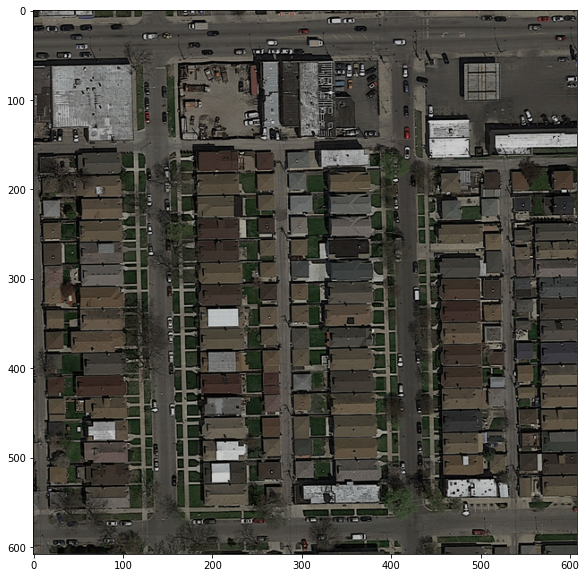

In [19]:
model3 = CnnModel()
model3.load('../w.h5')
# Run prediction on the img_idx-th image (from the test set)
img_idx = 1 # This value can be changed

test_dir = "../test_set_images/test"
direc = test_dir + "/test_" + str(img_idx) + ".png"
Xi = extract_img_features(direc, stride)

# Ensure compatibility with both Theano and Tensorflow
if K.image_data_format == 'th':
    Xi = np.rollaxis(Xi, 3, 1)

Zi = model3.model.predict(Xi)
Zi = Zi[:,0] > Zi[:,1]

img_ = load_image(direc)
w = img_.shape[0]
h = img_.shape[1]

predicted_im = label_to_img(w, h, patch_size, patch_size, Zi, stride)
plt.imshow(predicted_im)
cimg = concatenate_images(img_, predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(img_, predicted_im)
plt.imshow(new_img)